# **1. Introduction**

**Goals**:


*  Learn the usage of textual data
*  Get to know popular NLP-frameworks (NLTK, Spacy, Gensim)
*  Learn how to preprocess textual data for further analysis (tokenization, stemming/lemmatization, stopword removal, vectorization, similarity computation) 
* Get to know popular ML framework Scikit-learn
* Build model and evaluate it on test set
---

**Credit**: This tutorial is partly based on [blog post 1](https://curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/), [blog post 2](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) and the series "Fundamentals of NLP" by  Elvis Saravia ( [Twitter](https://twitter.com/omarsar0) | [LinkedIn](https://www.linkedin.com/in/omarsar/)), where the full project is maintained [here](https://github.com/dair-ai/nlp_fundamentals).

---

Before we start, we can first check the installed library  by following command line:

* ``pip freeze``: list all the python libaries & versions
* ``pip show <package_name>``: list the selected package_name

In [10]:
#!pip freeze

In [11]:
#!pip show nltk

In [12]:
# Initialize random seed to get consistent result
import numpy as np
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# **2. Data Analysis**

<!-- We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the [General Language Understanding Evaluation (GLUE) Benchmark](https://gluebenchmark.com/). -->
We'll use [The Google Play reviews Dataset](https://curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/) provided by Venelin Valkov. The dataset can then be used for sentiment analysis classification.

You can either download it locally and reupload it in specific folder in your Google Drive, or you can simply run the following code to download it.

In [13]:
# Load the data via pandas
import pandas as pd
df = pd.read_csv("reviews.csv")
print(df.shape)
df.head()

(15746, 11)


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [14]:
# Print the data infos & check for missing values
df.describe()

,score,thumbsUpCount
count,15746.000000,15746.000000
mean,3.062365,3.992570
std,1.310503,17.058478
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,1.000000
max,5.000000,448.000000


In [15]:
# Actually we only need the content(i.e. review) & the sentiment score for classification
df = df[['content', 'score']]
df.head(5)

,content,score
0,Update: After getting a response from the deve...,1
1,Used it for a fair amount of time without any ...,1
2,Your app sucks now!!!!! Used to be good but no...,1
3,"It seems OK, but very basic. Recurring tasks n...",1
4,Absolutely worthless. This app runs a prohibit...,1


In [16]:
# We can plot the score & check for the distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df.score)
plt.show()

ModuleNotFoundError: No module named 'seaborn'

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

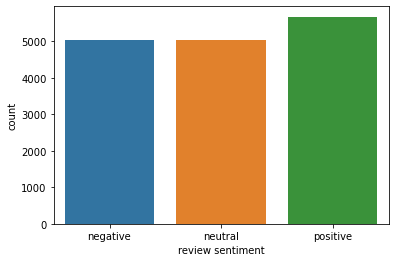

In [ ]:
# Since it's highly imbalanced, we can convert the score into 3 categories: negative(<3), neutral(=3), positive(>3)
# And replot it
def to_sentiment(score):
    score = int(score)
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(to_sentiment)

# Plot the score distribution after conversion
ax = sns.countplot(x=df.sentiment)
class_names = ['negative', 'neutral', 'positive']
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

# **3. Preprocessing**

In [ ]:
# Before preprocessing, we can first check the review content
df.content[0]

"Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK."

In [ ]:
df.content[3]

"It seems OK, but very basic. Recurring tasks need some work to be actually useful. For example, it would be nice to be able to set a task to be recurring on the first of every month, without only being able to set that up on the first of the month. Edit; I also just noticed that there is no dark theme. Both may be available as paid for options, but I'll never know, since they are basic options and without them, I have no reason to try this app, and thus will never pay for actual premium options."

## **3.1 Tokenization**
<div>
<img src=https://drive.google.com/uc?export=view&id=1h0ZNzohff1nUWMerrW50eDxY99ArRJTK width="800">
</div>

With any typical NLP task, one of the first steps is to tokenize your pieces of text into its individual words/tokens (process demonstrated in the figure above), the result of which is used to create so-called vocabularies that will be used in the langauge model you plan to build. This is actually one of the techniques that we will use the most throughout this series but here we stick to the basics.

Below I am showing you an example of a simple tokenizer without following any standards. All it does is extract tokens based on a white space seperator.

In [ ]:
# You can simply use split to tokenize the text by whitespace
doc = df.content[0]
for i, w in enumerate(doc.split(" ")):
    print("Token " + str(i) + ": " + w)

Token 0: Update:
Token 1: After
Token 2: getting
Token 3: a
Token 4: response
Token 5: from
Token 6: the
Token 7: developer
Token 8: I
Token 9: would
Token 10: change
Token 11: my
Token 12: rating
Token 13: to
Token 14: 0
Token 15: stars
Token 16: if
Token 17: possible.
Token 18: These
Token 19: guys
Token 20: hide
Token 21: behind
Token 22: confusing
Token 23: and
Token 24: opaque
Token 25: terms
Token 26: and
Token 27: refuse
Token 28: to
Token 29: budge
Token 30: at
Token 31: all.
Token 32: I'm
Token 33: so
Token 34: annoyed
Token 35: that
Token 36: my
Token 37: money
Token 38: has
Token 39: been
Token 40: lost
Token 41: to
Token 42: them!
Token 43: Really
Token 44: terrible
Token 45: customer
Token 46: experience.
Token 47: Original:
Token 48: Be
Token 49: very
Token 50: careful
Token 51: when
Token 52: signing
Token 53: up
Token 54: for
Token 55: a
Token 56: free
Token 57: trial
Token 58: of
Token 59: this
Token 60: app.
Token 61: If
Token 62: you
Token 63: happen
Token 64: to
Tok

**Question:**

**(a) What are the problems here with only the split function for tokenization?**

White space tokenization, where words are simply split by spaces, is a common technique for natural language processing (NLP). However, it can lead to several problems:

* **Punctuation**: White space tokenization does not take into account punctuation marks, which can change the meaning of a sentence. For example, "Let's eat, grandma!" and "Let's eat grandma!" have completely different meanings.

* **Contractions**: White space tokenization can also create problems with contractions, such as "can't" and "won't". These are typically treated as a single word, but can also be split into two words ("can" and "not").

* **Hyphenated words**: White space tokenization can also have difficulty with hyphenated words, which can be treated as separate words or as a single unit depending on the context.

* **Multi-word expressions**: White space tokenization also struggles with multi-word expressions, such as "New York" or "United States". These can be split into separate words or treated as a single unit depending on the context.

* **Ambiguity**: White space tokenization can be ambiguous, especially when dealing with languages that do not use spaces to separate words, such as Chinese and Japanese. In these cases, the meaning of the text can change depending on how it is segmented.

**(b) How can we improve the tokenization?**

Tokenization can come in different forms. For instance, more recently a lot of state-of-the-art NLP models such as [BERT](https://arxiv.org/pdf/1810.04805.pdf) make use of `subword` tokens in which frequent combinations of characters also form part of the vocabulary. This helps to deal with the so-called out of vocabulary (OOV) problem. We will discuss this in upcoming chapters, but if you are interested in reading more about this now, check this [paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf).

### **3.1.1 spaCy**

To demonstrate how you can achieve more reliable tokenization, we are going to use [spaCy](https://spacy.io/), which is an impressive and robust Python library for natural language processing. It comes with pretrained pipelines and currently supports tokenization and training for 60+ languages. It features state-of-the-art speed and neural network models for tagging, parsing, named entity recognition, text classification and more.

In particular, we are going to use the built-in tokenizer found [here](https://spacy.io/usage/linguistic-features#tokenization). You can also find the useful models for different languages [here](https://spacy.io/usage/models).

In [ ]:
# Colab has already spacy library installed
#!pip show spacy
#If you don't have it in your local machine, you can simply download the libraries
#!pip install -U spacy
#!pip install -U spacy-lookups-data
#!python -m spacy download en_core_web_sm

In [ ]:
#!pip install --upgrade --user tensorflow

In [ ]:
# !pip install --upgrade google-api-core
# !pip install --upgrade google-cloud-storage

In [ ]:
#!pip install spacy

In [ ]:
## Import the libraries
import spacy
## Load the language model for the language you need
nlp = spacy.load("en_core_web_sm")
## Do tokenization
doc = nlp(df.content[1])
for i, token in enumerate(doc):
    #print("Token {}: {}".format(str(i), token.text))
    print("Token {}: {} ({})".format(str(i), token.text, token.pos_))

Token 0: Used (VERB)
Token 1: it (PRON)
Token 2: for (ADP)
Token 3: a (DET)
Token 4: fair (ADJ)
Token 5: amount (NOUN)
Token 6: of (ADP)
Token 7: time (NOUN)
Token 8: without (ADP)
Token 9: any (DET)
Token 10: problems (NOUN)
Token 11: . (PUNCT)
Token 12: Suddenly (ADV)
Token 13: then (ADV)
Token 14: asked (VERB)
Token 15: me (PRON)
Token 16: to (PART)
Token 17: create (VERB)
Token 18: an (DET)
Token 19: account (NOUN)
Token 20: or (CCONJ)
Token 21: log (VERB)
Token 22: using (VERB)
Token 23: Google (PROPN)
Token 24: or (CCONJ)
Token 25: FB (PROPN)
Token 26: . (PUNCT)
Token 27: I (PRON)
Token 28: used (VERB)
Token 29: my (PRON)
Token 30: Google (PROPN)
Token 31: one (NOUN)
Token 32: only (ADV)
Token 33: to (PART)
Token 34: discover (VERB)
Token 35: everything (PRON)
Token 36: was (AUX)
Token 37: gone (VERB)
Token 38: ! (PUNCT)


All the code does is tokenize the text based on a pre-built language model.

Try putting different running text into the `nlp()` part of the code above. The tokenizer is quite robust and it includes a series of built-in rules that deal with exceptions and special cases such as those tokens that contain puctuations like "`" and ".", "-", etc. You can even add your own rules, find out how [here](https://spacy.io/usage/linguistic-features#special-cases).

Other tools you can use for tokenization are the [Keras Tokenizer API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer), [Hugging Face Tokenizer](https://github.com/huggingface/tokenizers) and [NLTK](https://www.nltk.org/), which we are going to use for our data.  

---

### **3.1.2 NLTK**

[NLTK](https://www.nltk.org/) stands for **Natural Language Toolkit**. It is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries.

In [ ]:
# Let's tokenize the data; we will do so using the nltk library 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%%time
all_texts = list(df.content)
all_texts_tokenized = [nltk.word_tokenize(t) for t in all_texts]
print(all_texts_tokenized[0])

['Update', ':', 'After', 'getting', 'a', 'response', 'from', 'the', 'developer', 'I', 'would', 'change', 'my', 'rating', 'to', '0', 'stars', 'if', 'possible', '.', 'These', 'guys', 'hide', 'behind', 'confusing', 'and', 'opaque', 'terms', 'and', 'refuse', 'to', 'budge', 'at', 'all', '.', 'I', "'m", 'so', 'annoyed', 'that', 'my', 'money', 'has', 'been', 'lost', 'to', 'them', '!', 'Really', 'terrible', 'customer', 'experience', '.', 'Original', ':', 'Be', 'very', 'careful', 'when', 'signing', 'up', 'for', 'a', 'free', 'trial', 'of', 'this', 'app', '.', 'If', 'you', 'happen', 'to', 'go', 'over', 'they', 'automatically', 'charge', 'you', 'for', 'a', 'full', 'years', 'subscription', 'and', 'refuse', 'to', 'refund', '.', 'Terrible', 'customer', 'experience', 'and', 'the', 'app', 'is', 'just', 'OK', '.']
CPU times: total: 3.09 s
Wall time: 7.47 s


## **3.2 Emoji detection**

Emoji lexicons are one of the key components for detecting emotions. 
Since emoji characters are a subset of a large Unicode character set, 
we will use the python package [emoji](https://github.com/carpedm20/emoji/) to demojize the emoji lexicons. 

In [ ]:
#!pip install emoji
import emoji

In [ ]:
# You can check a list of emoticons by emoji.UNICODE_EMOJI
print('Supported languages: {}'.format(list(emoji.LANGUAGES)))
print('First five emoticons with their english translation: {}'.format([(emoticon[0], emoticon[1]['en']) 
                                                                    for emoticon in list(emoji.EMOJI_DATA.items())[0:5]]))

Supported languages: ['en', 'es', 'ja', 'ko', 'pt', 'it', 'fr', 'de', 'fa', 'id', 'zh']
First five emoticons with their english translation: [('🥇', ':1st_place_medal:'), ('🥈', ':2nd_place_medal:'), ('🥉', ':3rd_place_medal:'), ('🆎', ':AB_button_(blood_type):'), ('🏧', ':ATM_sign:')]


In [ ]:
# We will first check one of the reviews which contain the emojis
print(all_texts[15])

This was originally a 5 star app, but now you can only use it by allowing it access to either your emails or Facebook! 😡😡😡 I am definitely not happy to allow this so have deleted the app. Would give it zero stars if I could.


In [ ]:
# Then we will use the demojize function to convert unicode set to text
emoji.demojize(all_texts[15], language='en')

'This was originally a 5 star app, but now you can only use it by allowing it access to either your emails or Facebook! :enraged_face::enraged_face::enraged_face: I am definitely not happy to allow this so have deleted the app. Would give it zero stars if I could.'

In [ ]:
# So to combine 3.1 tokenization and 3.2 Emoji detection together with lower case, we will do the following:
all_texts = list(df.content)
all_texts_preprocessed_tokenized = [nltk.word_tokenize(emoji.demojize(t.lower(), language='en')) for t in all_texts]
print(all_texts_preprocessed_tokenized[15])
all_texts_preprocessed = [' '.join(text) for text in all_texts_preprocessed_tokenized]
print(all_texts_preprocessed[15])

['this', 'was', 'originally', 'a', '5', 'star', 'app', ',', 'but', 'now', 'you', 'can', 'only', 'use', 'it', 'by', 'allowing', 'it', 'access', 'to', 'either', 'your', 'emails', 'or', 'facebook', '!', ':', 'enraged_face', ':', ':enraged_face', ':', ':enraged_face', ':', 'i', 'am', 'definitely', 'not', 'happy', 'to', 'allow', 'this', 'so', 'have', 'deleted', 'the', 'app', '.', 'would', 'give', 'it', 'zero', 'stars', 'if', 'i', 'could', '.']
this was originally a 5 star app , but now you can only use it by allowing it access to either your emails or facebook ! : enraged_face : :enraged_face : :enraged_face : i am definitely not happy to allow this so have deleted the app . would give it zero stars if i could .


To fit your needs, there are also some common text preprocessing steps:
* **lemmatization** (playing -> play)
* **stemming** (troubled -> troubl)
* **stop words removal** (a, the, is, are, ...)
* **punctuation removal**
* **abbreviation conversion** (b4 -> before)
* **lower case** (The -> the) 
* **digits conversion** (1549 -> 0000)
* **[regular expression](https://regexone.com/)**
* **sentence segmentation**

and more to explore.

**We leave the above as exercises for you to try out.**

In [ ]:
### Exercise: try out different preprocessing steps
### Your turn

In [ ]:
# Lemmatization
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print("am :", lemmatizer.lemmatize("am", pos="v"))  
print("are :", lemmatizer.lemmatize("are", pos="v"))
print("is :", lemmatizer.lemmatize("is", pos="v"))
print("was :", lemmatizer.lemmatize("was", pos="v"))
print("survival :", lemmatizer.lemmatize("survival"))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


am : be
are : be
is : be
was : be
survival : survival


In [ ]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
print("playing :", stemmer.stem("playing"))
print("played :", stemmer.stem("played"))
print("plays :", stemmer.stem("plays"))
print("survival :", stemmer.stem("survival"))

playing : play
played : play
plays : play
survival : surviv


In [ ]:
# Punctuations removal
import string
print(string.punctuation) 
doc = "Welcome to web mining course!!!"
print(doc.translate(str.maketrans('', '', string.punctuation)))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Welcome to web mining course


In [ ]:
# Sentence segmentation
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("I love coding and programming. I also love sleeping!")
for sent in doc.sents:
    print(sent.text)

I love coding and programming.
I also love sleeping!


# **4. Vectorization**

Many machine learning models require numeric representations in form of feature vectors as input. Transforming text to vectors is called **vectorization**.

When you are working with textual information, it is imperative to clean your data so as to be able to train more accurate machine learning (ML) models. 

One of the reasons why transformations like lemmatization and stemming are useful is for normalizing the text before you feed the output to an ML algorithm. For instance, if you are building a sentiment analysis model how can you tell the model that "smiling" and "smile" refer to the same concept? You may require stemming if you are using [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features combined with a machine learning algorithm such as [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). As you may suspect already, this also requires a really good tokenizer to come up with the features, especially when you work on noisy pieces of text that could be generated from users in a social media site.

With a wide variety of NLP tasks, one of the first big steps in the NLP pipeline is to create a vocabulary that will eventually be used to determine the inputs for the model representing the features. In modern NLP techniques such as pretrained language models, you need to process a text corpus. This requires a proper and more sophisticated sentence segmentation and tokenization as we discussed before.

## **4.1 Tf-Idf Vectorization (sparse)**

A simple and powerful technique, which is mostly used for traditional machine learning models is the so-called Tf-Idf vectorization.

Tf-idf is a product of two values:
* tf: term frequency (often log-transformed)
* idf: inverse document frequency



Term frequency (tf) measures how frequently the word t
appears in the document d

$$\text{tf}_{td}= \begin{cases} 1 + \text{log}_{10} \text{count}(t,d), & \text{if  count}(t,d) 
> 0 \\ 0, &\text{otherwise} \end{cases}$$

Inverse document frequency (idf) is inversely proportional
to the number of documents in a corpus that contain t
(frequently appeared words among documents will have lower idf values)

$$\text{idf}_t= \text{log}_{10} \frac{N}{\text{df}_t}$$

So, the tf-idf value for word t in document d is

$$\text{tfidf}_{td} = \text{tf}_{td}*\text{idf}_t$$ .

So tfidf values will promote document-specific words, and penalize non-specific words (e.g. a, the, ...)

[Gensim](https://radimrehurek.com/gensim/index.html) provides an implementation of a tfidf vectorizer.
Let's see how we can use this with our data.

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

# Tokenize content by whitespace
tokenized_content = [list(simple_preprocess(review)) for review in all_texts_preprocessed]
dct = Dictionary(tokenized_content)  # fit dictionary
corpus = [dct.doc2bow(line) for line in tokenized_content]
tfidf_model = TfidfModel(corpus)

print('Number of features: {}'.format(len(dct)))

Number of features: 10962


Let's inspect what numbers we get ...

In [ ]:
doc = 0 #Check for our first review in our dataset
print('Text 0:\n{}\n'.format(all_texts_preprocessed[0]))

# Inspect tf-idf scores of document sorted by the similarity score
for w,s in sorted(tfidf_model[corpus[doc]], reverse=True, key=lambda x: x[1]):
    print('{}:{}'.format(dct[w], s))

Text 0:
update : after getting a response from the developer i would change my rating to 0 stars if possible . these guys hide behind confusing and opaque terms and refuse to budge at all . i 'm so annoyed that my money has been lost to them ! really terrible customer experience . original : be very careful when signing up for a free trial of this app . if you happen to go over they automatically charge you for a full years subscription and refuse to refund . terrible customer experience and the app is just ok .

refuse:0.35477385861173566
terrible:0.2651223479693971
customer:0.26227242053190264
budge:0.2287673900887692
opaque:0.2287673900887692
experience:0.22369946470383262
careful:0.18307713790169963
signing:0.17574118312330317
annoyed:0.16648701490959536
hide:0.15237557220564932
terms:0.15174590526888254
charge:0.15113141251600623
happen:0.1482631997248816
refund:0.1381052491417779
original:0.13738688571463006
trial:0.1347001698838273
behind:0.12825620546755281
rating:0.11971148339

**You can see that there are actually some missing tokens after applying the tfidf-vectorizer (e.g. tokens with the length less than 2). Why is this the case? How can you modify it?**

In [ ]:
# Tokenize content by whitespace and decrease min length to 1
tokenized_content = [list(simple_preprocess(review, min_len=1)) for review in all_texts_preprocessed]
dct = Dictionary(tokenized_content)  # fit dictionary
corpus = [dct.doc2bow(line) for line in tokenized_content]
tfidf_model = TfidfModel(corpus)

print('Number of features: {}'.format(len(dct)))

Number of features: 11042


In [ ]:
doc = 0 #Check for our first review in our dataset
print('Text 0:\n{}\n'.format(all_texts_preprocessed[0]))

# Inspect tf-idf scores of document sorted by the similarity score
for w,s in sorted(tfidf_model[corpus[doc]], reverse=True, key=lambda x: x[1]):
    print('{}:{}'.format(dct[w], s))

Text 0:
update : after getting a response from the developer i would change my rating to 0 stars if possible . these guys hide behind confusing and opaque terms and refuse to budge at all . i 'm so annoyed that my money has been lost to them ! really terrible customer experience . original : be very careful when signing up for a free trial of this app . if you happen to go over they automatically charge you for a full years subscription and refuse to refund . terrible customer experience and the app is just ok .

refuse:0.353065815711946
terrible:0.2638459282641892
customer:0.2610097216750784
budge:0.22766599970483972
opaque:0.22766599970483972
experience:0.2226224736203597
careful:0.1821957211966176
signing:0.1748950850449132
annoyed:0.1656854706108236
hide:0.15164196681762643
terms:0.1510153313842088
charge:0.15040379707925092
happen:0.1475493931705286
refund:0.13744034758690193
original:0.13672544268839545
trial:0.13405166193098425
behind:0.12763872169363544
rating:0.119135137801753

In [ ]:
from gensim import matutils
# vectorize all documents with tf-idf
tfidf_vectorization_csr = matutils.corpus2csc(tfidf_model[corpus], num_terms=len(dct))
X_tfidf_vectorization = tfidf_vectorization_csr.T.toarray()

## **4.2 Word Embedding Vectorization (dense)**

**Intro**

Using TfIdf value for each token as the text representation will lead to the following problems:
* high dimensional feature vector due to large size of vocabulary (V) or unseen words
* lead to highly sparse vector (i.e. a lot of zeros)

Here comes the question: how can we represent a word by encoding the co-occurrence information within context, but having a more dense representation (d << V)?

**Distributional Hypothesis**
* Words which are similar in meaning occur in similar contexts
* Words that occur in the same contexts tend to have similar meanings

Learn dense word representations (e.g. d=50, 100, 300, ...) by expoiting co-occurrence statistics with neighboring words. Each word is represented by a dense vector and the dimension of the semantic representation d is usually much
smaller than the size of the vocabulary (d << V). All dimensions contain real-valued numbers (possibly normalized between −1 and 1).

* **CBOW**: predict center word from neighboring words
* **Skip-gram**: predict neighboring words from center word

<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*cuOmGT7NevP9oJFJfVpRKA.png" width=800></img>
</p>

* **Glove**: leveraging global word to word co-occurance counts on the entire corpus
* **FastText**: represent words by neighboring ngrams, capturing out-of-vocabulary (OOV) words

In order to use pretrained word embeddings, you just have to download the vectors from the authors web site. Often, it is just a text file with the following structure:
\<word> \<tab> \<vector> .

Here, we can again make use of gensim, which already provides some [pretrained models](https://github.com/RaRe-Technologies/gensim-data).

In [ ]:
import gensim.downloader as api

In [ ]:
# Load the glove model
glove_model = api.load("glove-wiki-gigaword-50")

In [ ]:
print('Vocab size: {}'.format(len(glove_model.index_to_key)))

Vocab size: 400000


In [ ]:
glove_model["glass"]

array([ 1.3121e-02,  7.1226e-01, -2.2566e-01,  1.2239e-01,  7.2298e-01,
        5.5787e-01, -6.4484e-03, -7.0540e-01, -3.2206e-01,  1.2796e-01,
       -7.7531e-02,  5.5125e-02,  3.8379e-02,  9.5295e-01,  4.3992e-02,
        4.5025e-01, -1.1435e-01, -1.2781e-03, -3.2919e-01, -1.8721e+00,
        1.0702e+00, -1.1634e-01, -6.2644e-01, -6.1095e-01, -4.1408e-01,
       -5.5053e-01, -7.0974e-01,  1.4821e+00,  5.3134e-01, -5.3206e-01,
        2.1137e+00, -1.0961e+00,  4.8239e-01, -1.6375e-01, -6.2490e-01,
        7.2829e-01,  5.1436e-01,  8.4971e-01,  1.0365e+00,  7.4664e-02,
        1.0125e+00,  4.7441e-01,  4.2126e-01, -4.9965e-02,  5.3149e-01,
        1.2321e+00, -2.7239e-01, -1.4639e+00, -3.3859e-01, -9.7446e-01],
      dtype=float32)

In [ ]:
glove_model.most_similar("glass")

[('plastic', 0.79425048828125),
 ('metal', 0.7708716988563538),
 ('walls', 0.7700635194778442),
 ('marble', 0.7638523578643799),
 ('wood', 0.7624280452728271),
 ('ceramic', 0.7602593302726746),
 ('pieces', 0.7589112520217896),
 ('stained', 0.7528817653656006),
 ('tile', 0.748193621635437),
 ('furniture', 0.7463858723640442)]

We can transform, i.e., vectorize, our text by looking up the pretrained embedding for each word.

In [ ]:
all_texts_tokenized_embedded = [[glove_model[w] for w in t if w in glove_model]  for t in all_texts_preprocessed]
all_texts_tokenized_embedded[0][0:5]

[array([-0.25676 ,  0.8549  ,  1.1003  ,  0.95363 ,  0.36585 , -1.3029  ,
         1.0754  , -0.18461 , -0.67674 ,  0.37637 , -0.029637,  0.51698 ,
        -0.19248 , -0.41863 , -0.71144 ,  0.12564 , -0.42965 ,  0.61456 ,
         0.41819 ,  0.27606 , -0.48635 , -0.32585 ,  0.67748 ,  0.15916 ,
         0.35051 , -0.29393 , -0.80439 , -0.15939 ,  0.012475, -0.58404 ,
         2.1353  , -0.1547  , -0.5739  ,  1.4522  ,  0.6124  , -0.68752 ,
         1.2839  , -0.54631 , -0.35737 ,  0.57323 ,  0.3546  , -0.37465 ,
        -0.74628 , -0.074561, -0.48471 ,  0.067343, -0.039338, -0.22177 ,
         0.099708,  0.55553 ], dtype=float32),
 array([-3.5559e-01,  1.2386e+00,  1.4348e+00,  1.0447e+00,  1.0335e+00,
         1.0445e-01,  2.7760e-01, -1.2675e+00, -9.5788e-01, -5.9603e-01,
        -1.8280e-01, -1.8247e-02, -9.3553e-01, -4.9706e-01,  8.5845e-03,
         8.6971e-01, -3.5250e-01, -1.7587e-01, -6.7203e-01, -4.9188e-01,
         4.9252e-05,  1.9287e-01,  1.2353e+00,  7.1928e-01, -3.7632e-

Now, we have assigned a vector to each word. But how to get a sentence representation? For instance, we can just average the individual word vectors.


In [ ]:
import numpy as np
all_texts_tokenized_embedded = [[glove_model[w].astype(float) for w in t if w in glove_model] for t in all_texts_preprocessed]
X_all_texts_tokenized_embedded_averaged = [np.average(t, axis=0) for t in all_texts_tokenized_embedded]

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Usuario\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Further find out that there are some texts which are not representative by using glove
for i, k in enumerate(X_all_texts_tokenized_embedded_averaged):
    if np.isnan(k).any():
        print(all_texts_preprocessed[i])
    
# For these cases we can simply assign a random word vector from gensim.model
for i, k in enumerate(X_all_texts_tokenized_embedded_averaged):
    if np.isnan(k).any():
        X_all_texts_tokenized_embedded_averaged[i]=glove_model[random.choice(glove_model.index_to_key)]

یاشار
شكرا
♡♡
عملي جدآ
提醒方式可設定成全螢幕鬧鐘模式，不會錯過


In [ ]:
X_all_texts_tokenized_embedded_averaged = np.array(X_all_texts_tokenized_embedded_averaged)
X_all_texts_tokenized_embedded_averaged.shape

(15746, 50)

# **5. ML Framework: scikit-learn (sklearn)**

[Scikit-learn](https://scikit-learn.org/stable/) (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means...etc, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

## **5.1 Classification**

In [ ]:
# Now our input can either be X_tfidf_vectorization or X_all_texts_tokenized_embedded_averaged
# Case1: X = X_tfidf_vectorization

X = X_tfidf_vectorization
print(X.shape)
Y = np.array(list(df['sentiment']))
print(Y.shape)

(15746, 11042)
(15746,)


In [ ]:
from sklearn.model_selection import train_test_split
# split train, val, test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
print(len(X_train), len(X_val), len(X_test))

12596 1575 1575


In [ ]:
# SGDClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Initialize list of classifiers
classifiers_to_test = [
    ('SGD trained for 200 iters', SGDClassifier(max_iter = 200, random_state=RANDOM_SEED)),
    ('SGD trained for 200 iters, lr=adaptive, eta0=0.1, class_weights=balanced', SGDClassifier(max_iter = 200, learning_rate = 'adaptive', eta0=0.1, class_weight='balanced', random_state=RANDOM_SEED)),
    ('SGD trained for 200 iters, lr=adaptive, eta0=0.1, class_weights=balanced, loss=log',SGDClassifier(max_iter = 200, learning_rate = 'adaptive', eta0=0.1, class_weight='balanced', loss='log_loss', random_state=RANDOM_SEED))
]

# train evaluate classifiers
for name, classifier in classifiers_to_test:
    classifier.fit(X_train, y_train)

    # Predict Class
    y_pred = classifier.predict(X_val)

    # Accuracy 
    print('Classifier: {}'.format(name))
    print('Accuracy: {}'.format(accuracy_score(y_val, y_pred)*100))
    P, R, F1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
    print('P: {}, R:{}, F1: {}'.format(P*100, R*100, F1*100))
    print('')

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Evaluate best classifier on test set
y_pred = classifiers_to_test[1][1].predict(X_test)

# Accuracy 
print('Classifier: {}'.format(name))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('P: {}, R:{}, F1: {}'.format(P, R, F1))

In [ ]:
# Case2: X = X_all_texts_tokenized_embedded_averaged
# If our input is the average embedding for the text tokens

X = X_all_texts_tokenized_embedded_averaged
Y = np.array(list(df['sentiment']))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)

In [ ]:
# Initialize list of classifiers
classifiers_to_test = [
    ('SGD trained for 200 iters', 
         SGDClassifier(max_iter = 200, random_state=RANDOM_SEED)),
    ('SGD trained for 200 iters, lr=adaptive, eta0=0.1, class_weights=balanced', 
         SGDClassifier(max_iter = 200, learning_rate = 'adaptive', eta0=0.1, class_weight='balanced', random_state=RANDOM_SEED)),
    ('SGD trained for 200 iters, lr=adaptive, eta0=0.1, class_weights=balanced, loss=log',
        SGDClassifier(max_iter = 200, learning_rate = 'adaptive', eta0=0.1, class_weight='balanced', loss='log_loss', random_state=RANDOM_SEED))
]

# train evaluate classifiers
for name, classifier in classifiers_to_test:
    classifier.fit(X_train, y_train)

    # Predict Class
    y_pred = classifier.predict(X_val)

    # Accuracy 
    print('Classifier: {}'.format(name))
    print('Accuracy: {}'.format(accuracy_score(y_val, y_pred)))
    P, R, F1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
    print('P: {}, R:{}, F1: {}'.format(P, R, F1))
    print('')

In [ ]:
# Evaluate best classifier on test set
y_pred = classifiers_to_test[2][1].predict(X_test)

# Accuracy 
print('Classifier: {}'.format(name))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('P: {}, R:{}, F1: {}'.format(P, R, F1))

Use Cross-Validation for hyperparameter tuning.

**Running the following cell is computationally expensive and will take some time!**

In [ ]:
# Use Cross Validation to tune hyperparameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

X = X_tfidf_vectorization
Y = np.array(list(df['sentiment']))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

# create an classifier
classifier = SGDClassifier(max_iter=200, learning_rate = 'adaptive', class_weight='balanced', random_state=RANDOM_SEED)

# specify the parameter grid
parameters = {
    'eta0': [0.1, 0.001, 0.0001]
}

# specify the cross validation
stratified_5_fold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create the grid search instance
grid_search_estimator = GridSearchCV(classifier, parameters, scoring='accuracy', cv=stratified_5_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(X_train,y_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

# Predict Class
y_pred = grid_search_estimator.predict(X_test)

# Accuracy 
print('Classifier: {}'.format(name))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('P: {}, R:{}, F1: {}'.format(P, R, F1))
print('')

In [ ]:
### How about writing a prediction function for inputing an unseen text, and check the predicted result.
x_new = "I like this app. It's super useful!😄"
x_new_preprocessed = ' '.join(nltk.word_tokenize(emoji.demojize(x_new.lower(), language='en')))

# Vectorize with gensim
x_new_preprocessed_corpus = dct.doc2bow(simple_preprocess(x_new_preprocessed))
x_new_preprocessed_tfidf = tfidf_model[x_new_preprocessed_corpus]

# Convert vectorization to process in sklearn
x_new_preprocessed_tfidf_csr = matutils.corpus2csc([x_new_preprocessed_tfidf], num_terms=len(dct))
x_new_preprocessed_tfidf_vectorization = x_new_preprocessed_tfidf_csr.T.toarray()
print(x_new_preprocessed_tfidf_vectorization)

mapping_class = {0: "negative", 1: "neutral", 2: "positive"}
print('Predicted Class: {}'.format(mapping_class[grid_search_estimator.predict(x_new_preprocessed_tfidf_vectorization)[0]]))

### More advanced: try fasttext embedding instead of glove to deal with OOV words
https://github.com/facebookresearch/fastText/
1. !pip install fasttext
2. Download the model from their website

> model = fasttext.load_model("model_filename.bin")

> model = fasttext.train_unsupervised('data.txt', model='skipgram')

3. try other classifiers from scikit-learn 

In [ ]:
!pip install --upgrade wheel

  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1


In [ ]:
pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [43 lines of output]
  C:\Users\Usuario\anaconda3\lib\site-packages\setuptools\dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          By 2023-Sep-26, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  running bdist_wheel
  running build
  running build_py
  creating build

In [ ]:
import fasttext
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

ModuleNotFoundError: No module named 'fasttext'